# Exploratory Data Analysis

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

In [2]:
DATA_ROOT = Path("/kaggle/input/csiro-biomass")  # Kaggle
TRAIN_CSV = DATA_ROOT / "train.csv"

TARGET_COLS = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

R2_WEIGHTS = {
    "Dry_Green_g": 0.1,
    "Dry_Dead_g": 0.1,
    "Dry_Clover_g": 0.1,
    "GDM_g": 0.2,
    "Dry_Total_g": 0.5,
}

The SigLIP and DinoV3 training doesn't use season/month/year features. I'm just using it here for EDA and Dataset Understanding

In [3]:
def season_from_month(month: int) -> str:
    if month in [12, 1, 2]:
        return "Summer"
    if month in [3, 4, 5]:
        return "Autumn"
    if month in [6, 7, 8]:
        return "Winter"
    return "Spring"


def load_and_preprocess_train(train_csv: Path) -> pd.DataFrame:
    """
    Reads train.csv (long format) and returns a wide dataframe:
    one row per image + metadata + targets, plus derived features.
    """
    train_long = pd.read_csv(train_csv)

    # Pivot to wide (one row per image)
    df = train_long.pivot_table(
        index=["image_path", "Sampling_Date", "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"],
        columns="target_name",
        values="target",
        aggfunc="mean",
    ).reset_index()

    df["image_id"] = df["image_path"].astype(str).apply(lambda p: Path(p).stem)

    # Dates + time features
    df["Sampling_Date"] = pd.to_datetime(df["Sampling_Date"], errors="coerce")
    df["year"] = df["Sampling_Date"].dt.year
    df["month"] = df["Sampling_Date"].dt.month
    df["dayofyear"] = df["Sampling_Date"].dt.dayofyear
    df["season"] = df["month"].apply(lambda m: season_from_month(int(m)) if pd.notna(m) else np.nan)

    # Physical consistency features
    df["sum_components"] = df["Dry_Green_g"] + df["Dry_Dead_g"] + df["Dry_Clover_g"]
    df["constraint_error"] = (df["Dry_Total_g"] - df["sum_components"]).abs()

    # Ratios
    denom = (df["Dry_Total_g"].abs() + 1e-6)
    df["green_ratio"] = df["Dry_Green_g"] / denom
    df["dead_ratio"] = df["Dry_Dead_g"] / denom
    df["clover_ratio"] = df["Dry_Clover_g"] / denom

    return df


df = load_and_preprocess_train(TRAIN_CSV)

In [4]:
print("Shape: ", df.shape)
df.head()

Shape:  (357, 21)


target_name              image_path Sampling_Date State            Species  \
0            train/ID1011485656.jpg    2015-09-04   Tas    Ryegrass_Clover   
1            train/ID1012260530.jpg    2015-04-01   NSW            Lucerne   
2            train/ID1025234388.jpg    2015-09-01    WA  SubcloverDalkeith   
3            train/ID1028611175.jpg    2015-05-18   Tas           Ryegrass   
4            train/ID1035947949.jpg    2015-09-11   Tas           Ryegrass   

target_name  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  \
0                     0.62         4.6667        0.0000     31.9984   
1                     0.55        16.0000        0.0000      0.0000   
2                     0.38         1.0000        6.0500      0.0000   
3                     0.66         5.0000        0.0000     30.9703   
4                     0.54         3.5000        0.4343     23.2239   

target_name  Dry_Green_g  Dry_Total_g  ...      image_id  year  month  \
0                16.2751      48.2735  ...  ID1011485656  2015      9   
1                 7.6000       7.6000  ...  ID1012260530  2015      4   
2                 0.0000       6.0500  ...  ID1025234388  2015      9   
3                24.2376      55.2079  ...  ID1028611175  2015      5   
4                10.5261      34.1844  ...  ID1035947949  2015      9   

target_name  dayofyear  season sum_components  constraint_error  green_ratio  \
0                  247  Spring        48.2735            0.0000     0.337144   
1                   91  Autumn         7.6000            0.0000     1.000000   
2                  244  Spring         6.0500            0.0000     0.000000   
3                  138  Autumn        55.2079            0.0000     0.439024   
4                  254  Spring        34.1843            0.0001     0.307921   

target_name  dead_ratio  clover_ratio  
0              0.662856      0.000000  
1              0.000000      0.000000  
2              0.000000      1.000000  
3              0.560976      0.000000  
4              0.679371      0.012705  

[5 rows x 21 columns]

**Data Quality Checks**

In [5]:
def analyze_data_quality(df: pd.DataFrame) -> None:
    print("\n" + "=" * 80)
    print("DATA QUALITY CHECK")
    print("=" * 80)

    print("\nColumns:", df.columns.tolist())
    print("\nDtypes:\n", df.dtypes)

    missing = df.isna().sum().sort_values(ascending=False)
    missing = missing[missing > 0]
    print("\nMissing values (non-zero):")
    print(missing if len(missing) else "None")

    dup_ids = df["image_id"].duplicated().sum()
    dup_paths = df["image_path"].duplicated().sum()
    print(f"\nDuplicate image_id rows: {dup_ids}")
    print(f"Duplicate image_path rows: {dup_paths}")

    print("\nBasic dataset stats:")
    print(df[["State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"]].describe(include="all"))

analyze_data_quality(df)


DATA QUALITY CHECK

Columns: ['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g', 'image_id', 'year', 'month', 'dayofyear', 'season', 'sum_components', 'constraint_error', 'green_ratio', 'dead_ratio', 'clover_ratio']

Dtypes:
 target_name
image_path                  object
Sampling_Date       datetime64[ns]
State                       object
Species                     object
Pre_GSHH_NDVI              float64
Height_Ave_cm              float64
Dry_Clover_g               float64
Dry_Dead_g                 float64
Dry_Green_g                float64
Dry_Total_g                float64
GDM_g                      float64
image_id                    object
year                         int32
month                        int32
dayofyear                    int32
season                      object
sum_components             float64
constraint_error           float64
green_ratio                f

In [6]:
def target_statistics(df: pd.DataFrame, target_cols: list) -> pd.DataFrame:
    stats = []
    
    for t in target_cols:        
        x = df[t].dropna().astype(float)
        
        stats.append({
            "target": t,
            "count": len(x),
            "mean": x.mean(),
            "std": x.std(),
            "min": x.min(),
            "p25": x.quantile(0.25),
            "median": x.median(),
            "p75": x.quantile(0.75),
            "max": x.max(),
            "skew": x.skew(),
            "kurtosis": x.kurtosis(),
            "cv": (x.std() / (x.mean() + 1e-9)),
        })
        
    out = pd.DataFrame(stats).sort_values("target")
    return out

ts = target_statistics(df, TARGET_COLS)
print("\nTARGET STATS:")
display(ts)


TARGET STATS:


target  count       mean        std   min      p25   median      p75  \
2  Dry_Clover_g    357   6.649692  12.117761  0.00   0.0000   1.4235   7.2429   
1    Dry_Dead_g    357  12.044548  12.402007  0.00   3.2000   7.9809  17.6378   
0   Dry_Green_g    357  26.624722  25.401232  0.00   8.8000  20.8000  35.0834   
4   Dry_Total_g    357  45.318097  27.984015  1.04  25.2715  40.3000  57.8800   
3         GDM_g    357  33.274414  24.935822  1.04  16.0261  27.1082  43.6757   

        max      skew  kurtosis        cv  
2   71.7865  2.841982  9.068200  1.822304  
1   83.8407  1.761367  4.199735  1.029678  
0  157.9836  1.751446  3.911708  0.954047  
4  185.7000  1.428526  3.077529  0.617502  
3  157.9836  1.559033  3.048525  0.749399

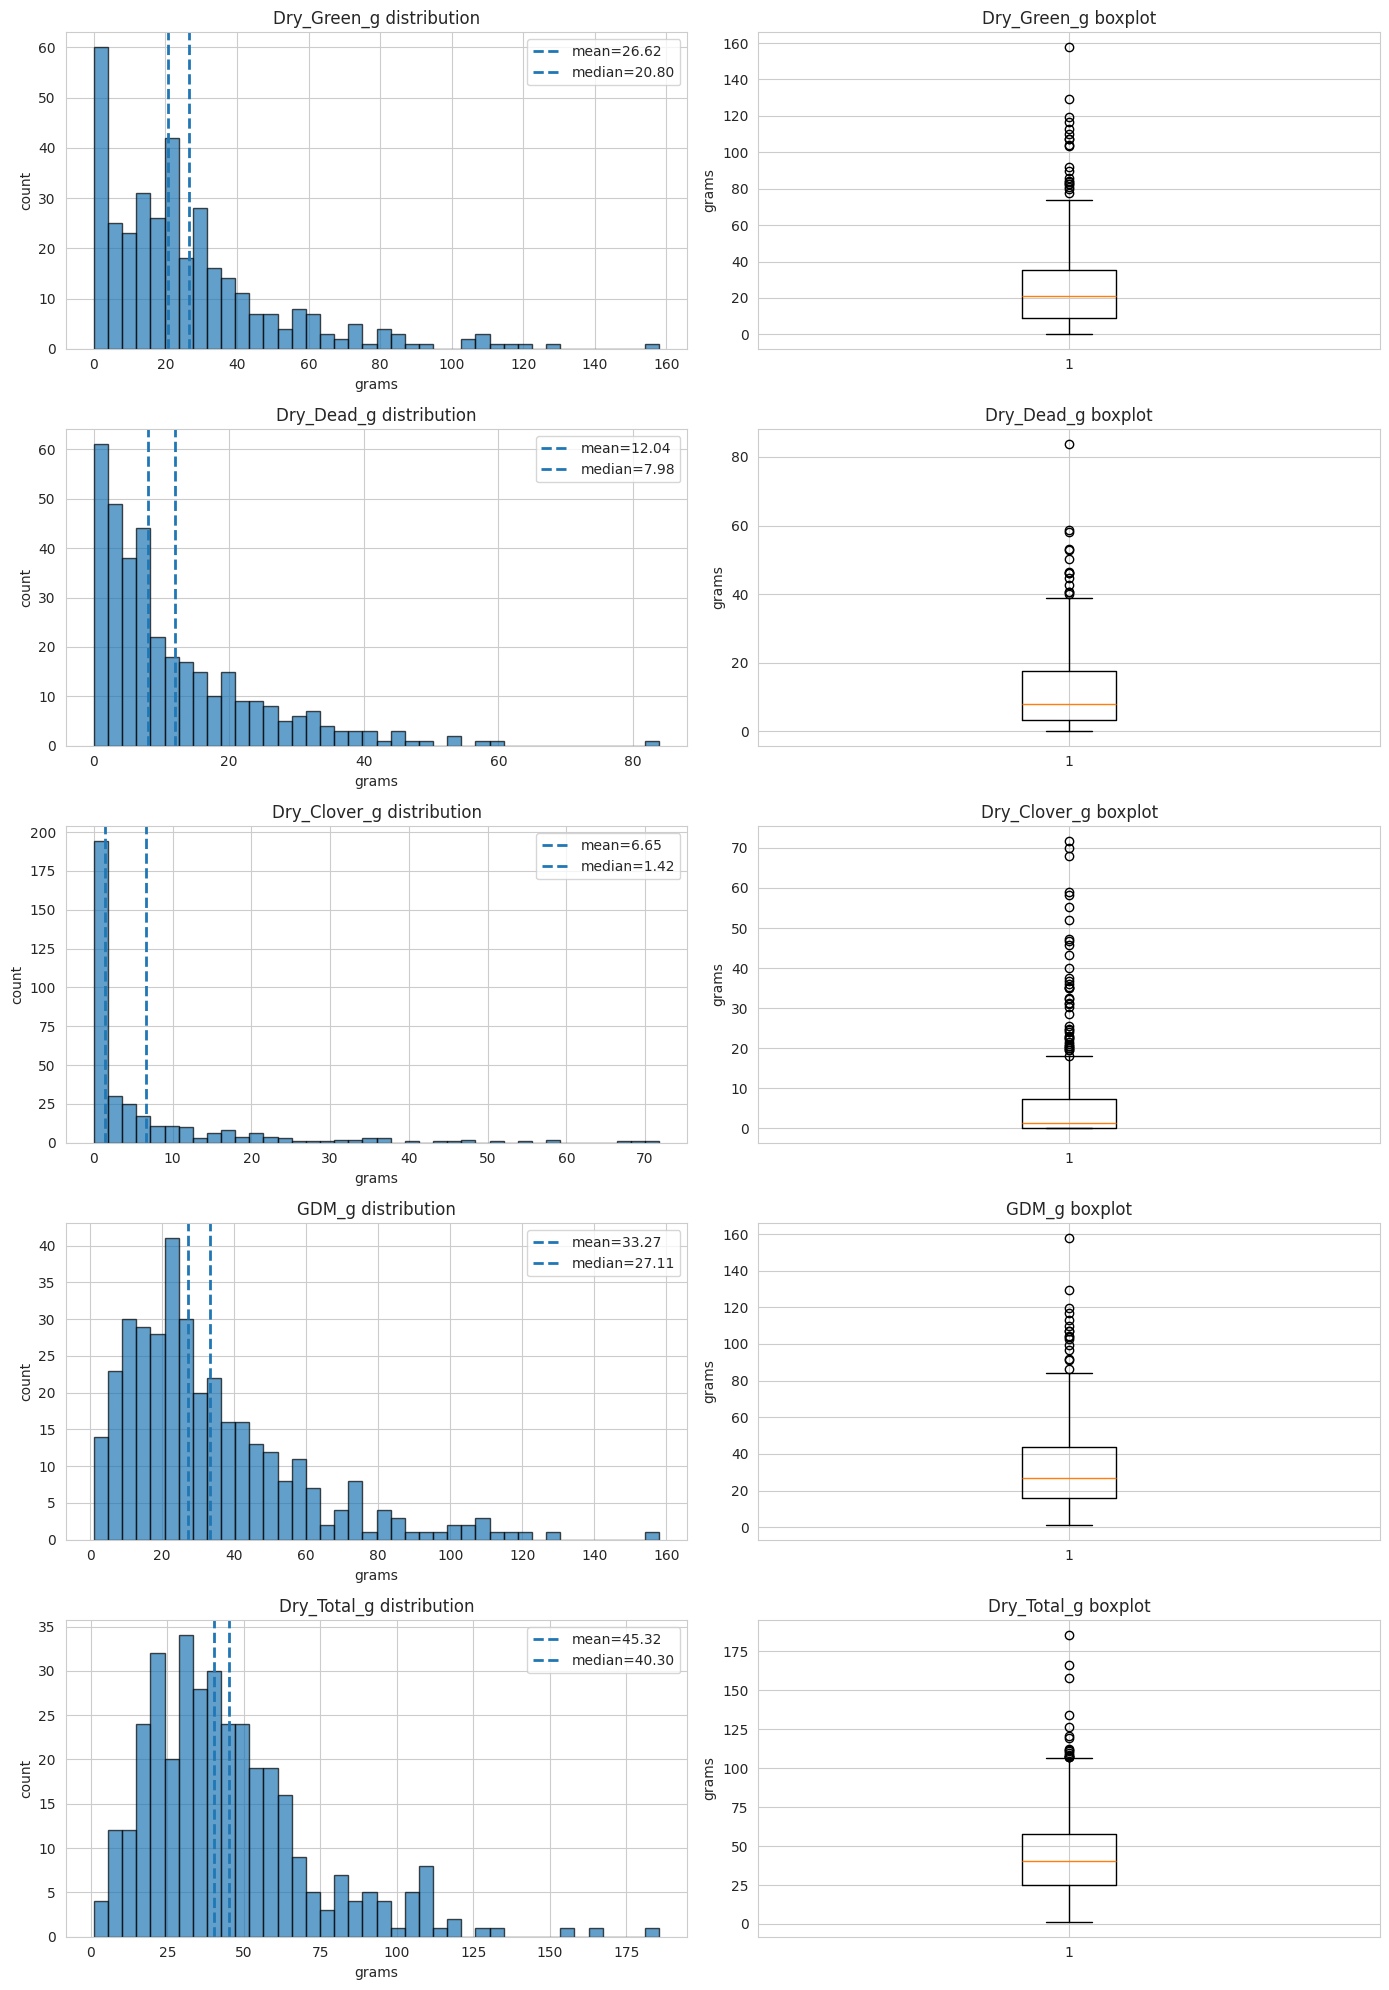

In [7]:
def plot_target_distributions(df: pd.DataFrame, target_cols: list) -> None:
    n = len(target_cols)
    fig, axes = plt.subplots(n, 2, figsize=(14, 4*n)) #creates a matplotlib figure with a grid of subplots

    for i, t in enumerate(target_cols):
        x = df[t].dropna().astype(float)

        # Histogram
        ax = axes[i, 0]
        ax.hist(x, bins=40, edgecolor="black", alpha=0.7)
        ax.axvline(x.mean(), linestyle="--", linewidth=2, label=f"mean={x.mean():.2f}")
        ax.axvline(x.median(), linestyle="--", linewidth=2, label=f"median={x.median():.2f}")
        ax.set_title(f"{t} distribution")
        ax.set_xlabel("grams")
        ax.set_ylabel("count")
        ax.legend()

        # Boxplot
        ax = axes[i, 1]
        ax.boxplot(x, vert=True)
        ax.set_title(f"{t} boxplot")
        ax.set_ylabel("grams")

    plt.tight_layout()
    plt.show()

plot_target_distributions(df, TARGET_COLS)


**Insight:** Targets are strongly right-skewed with many low-biomass samples and a small number of extreme high outliers; Clover is especially near-zero heavy, while GDM/Total have the widest spread.

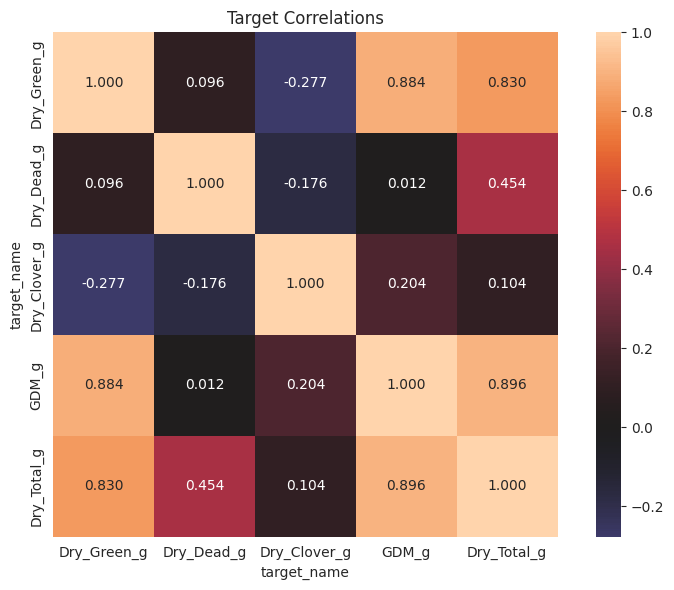


Strongest correlations:


target_name   target_name
GDM_g         Dry_Total_g    0.896441
Dry_Green_g   GDM_g          0.884257
              Dry_Total_g    0.830315
Dry_Dead_g    Dry_Total_g    0.453912
Dry_Clover_g  GDM_g          0.204213
dtype: float64


Weakest correlations:


target_name   target_name 
Dry_Clover_g  Dry_Total_g     0.104185
Dry_Green_g   Dry_Dead_g      0.095554
Dry_Dead_g    GDM_g           0.012028
              Dry_Clover_g   -0.175548
Dry_Green_g   Dry_Clover_g   -0.276582
dtype: float64

In [8]:
def plot_target_correlations(df: pd.DataFrame, target_cols: list) -> None:

    #compute pearson correlation matrix
    corr = df[target_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".3f", square=True, center=0)
    plt.title("Target Correlations")
    plt.tight_layout()
    plt.show()

    # strongest/weakest pairs
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = upper.stack().sort_values(ascending=False)
    print("\nStrongest correlations:")
    display(pairs.head(5))
    print("\nWeakest correlations:")
    display(pairs.tail(5))

plot_target_correlations(df, TARGET_COLS)

**Insights**

* Dry_Total_g is strongly correlated with GDM_g (0.896) and also fairly strongly with Dry_Green_g (0.830). This makes sense because Total is basically “living + dead”.

* GDM_g is strongly correlated with Dry_Green_g (0.884), since GDM includes the green component.

* Dry_Dead_g has a moderate correlation with Dry_Total_g (0.454), meaning dead matter contributes to total biomass but varies somewhat independently from green.

* Clover is weakly related to everything else:

    *  small positive with GDM (0.204) / Total (0.104)

    * negative with Green (-0.277) and Dead (-0.176)

     So clover behaves differently from the main biomass signals. This means that Clover is the most independent (hardest) target and may benefit from separate handling or heavier reliance on visual cues.

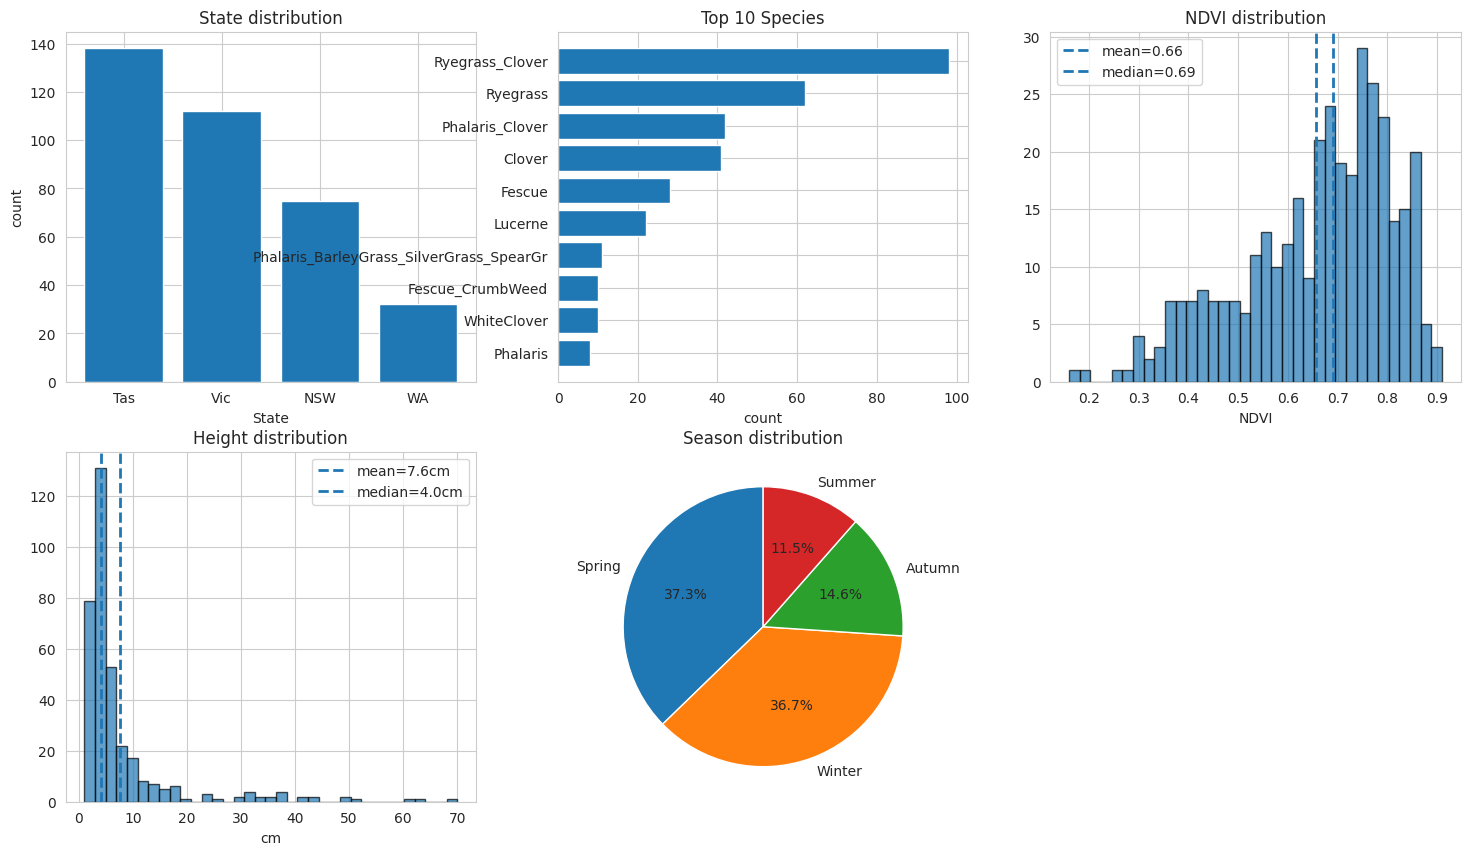

In [9]:
def plot_metadata_distributions(df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    fig.delaxes(axes[5])

    # State
    state_counts = df["State"].value_counts()
    axes[0].bar(state_counts.index.astype(str), state_counts.values)
    axes[0].set_title("State distribution")
    axes[0].set_xlabel("State")
    axes[0].set_ylabel("count")

    # Top 10 species combos
    top_species = df["Species"].value_counts().head(10) #counts species categories and keeps top 10 most common
    axes[1].barh(range(len(top_species)), top_species.values)
    axes[1].set_yticks(range(len(top_species)))
    axes[1].set_yticklabels([str(s)[:40] for s in top_species.index])
    axes[1].invert_yaxis()
    axes[1].set_title("Top 10 Species")
    axes[1].set_xlabel("count")

    # NDVI
    ndvi = df["Pre_GSHH_NDVI"].dropna().astype(float)
    axes[2].hist(ndvi, bins=35, edgecolor="black", alpha=0.7)
    axes[2].axvline(ndvi.mean(), linestyle="--", linewidth=2, label=f"mean={ndvi.mean():.2f}")
    axes[2].axvline(ndvi.median(), linestyle="--", linewidth=2, label=f"median={ndvi.median():.2f}")
    axes[2].set_title("NDVI distribution")
    axes[2].set_xlabel("NDVI")
    axes[2].legend()

    # Height
    h = df["Height_Ave_cm"].dropna().astype(float)
    axes[3].hist(h, bins=35, edgecolor="black", alpha=0.7)
    axes[3].axvline(h.mean(), linestyle="--", linewidth=2, label=f"mean={h.mean():.1f}cm")
    axes[3].axvline(h.median(), linestyle="--", linewidth=2, label=f"median={h.median():.1f}cm")
    axes[3].set_title("Height distribution")
    axes[3].set_xlabel("cm")
    axes[3].legend()

    # Season
    season_counts = df["season"].value_counts()
    axes[4].pie(
        season_counts.values, 
        labels=season_counts.index, 
        autopct="%1.1f%%", #Put the percentage text on each slice. %1.1f = one decimal place (e.g., 37.5). %% = literally prints a %
        startangle=90 # Rotate the pie so the first slice starts at 90 degrees (top of the circle) instead of the default (usually to the right).
    )
    axes[4].set_title("Season distribution")


plot_metadata_distributions(df)


Outliers for Dry_Green_g
  IQR bounds: [-30.63, 74.51] -> 20 rows (5.6%)
  Z>3.0 -> 10 rows (2.8%)


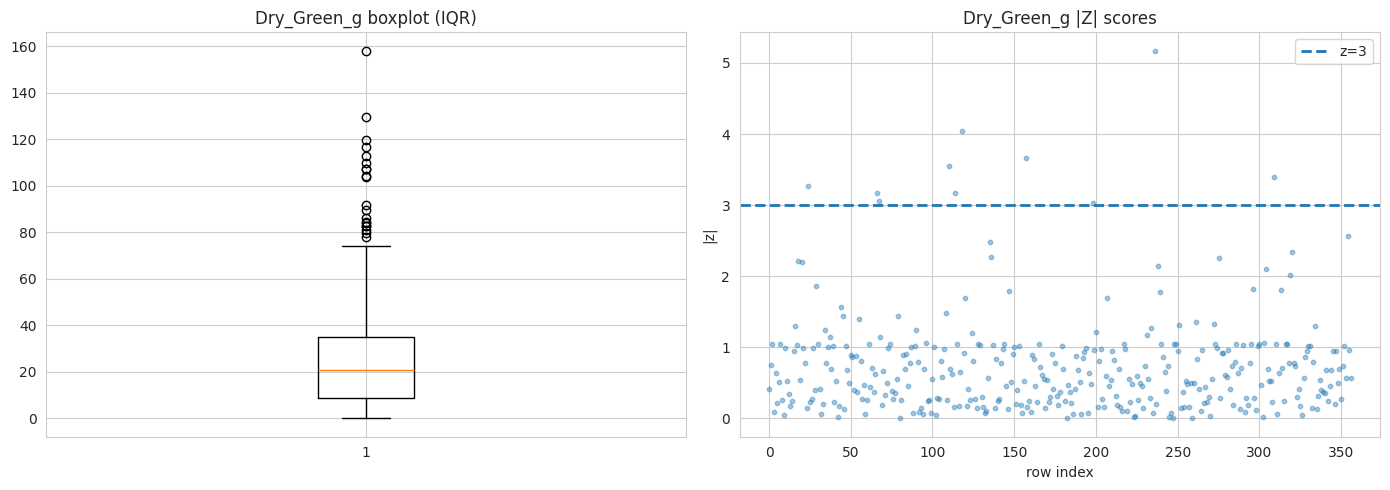


Outliers for Dry_Dead_g
  IQR bounds: [-18.46, 39.29] -> 14 rows (3.9%)
  Z>3.0 -> 6 rows (1.7%)


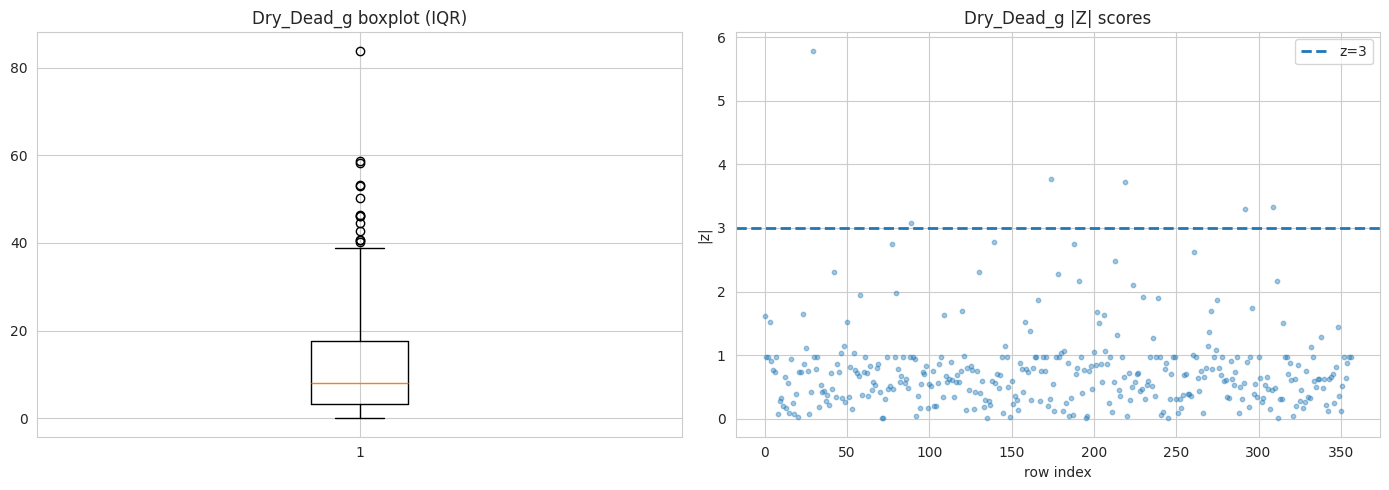


Outliers for Dry_Clover_g
  IQR bounds: [-10.86, 18.11] -> 41 rows (11.5%)
  Z>3.0 -> 11 rows (3.1%)


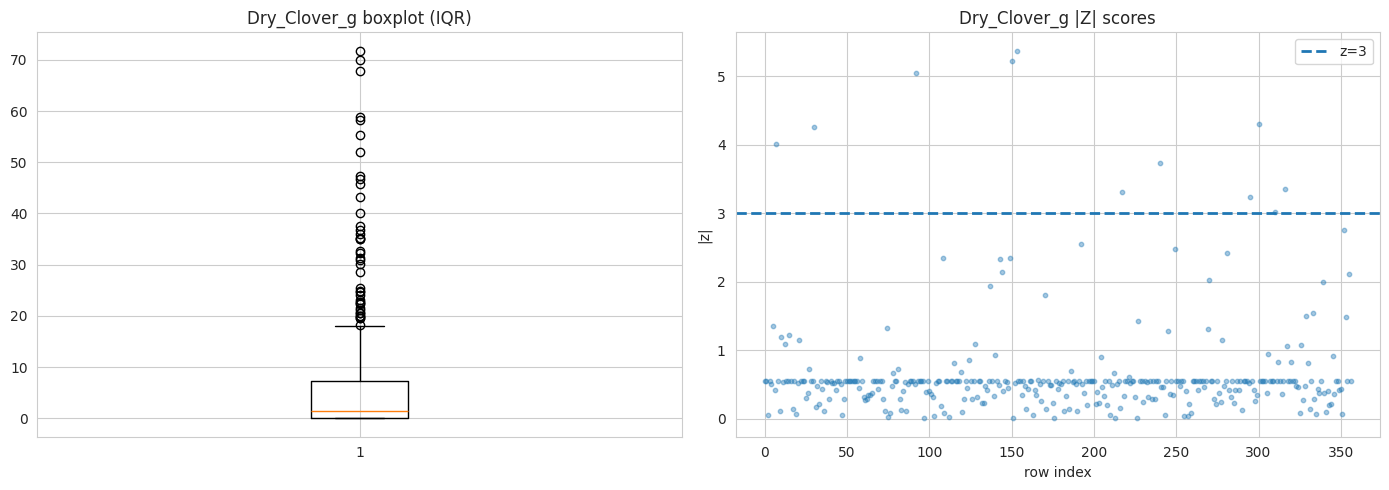


Outliers for GDM_g
  IQR bounds: [-25.45, 85.15] -> 16 rows (4.5%)
  Z>3.0 -> 6 rows (1.7%)


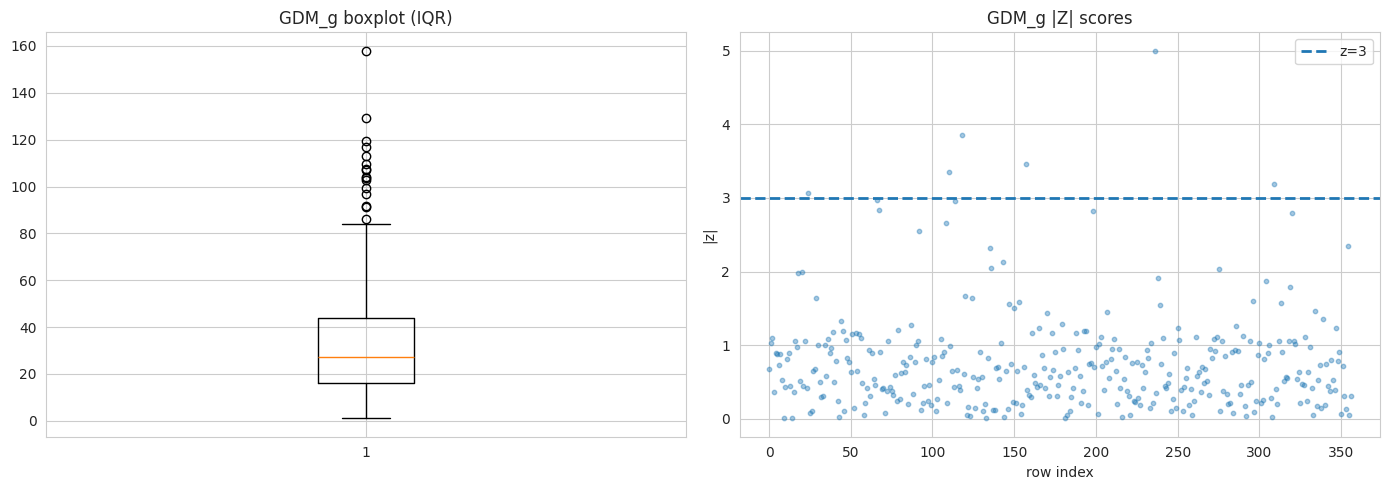


Outliers for Dry_Total_g
  IQR bounds: [-23.64, 106.79] -> 16 rows (4.5%)
  Z>3.0 -> 4 rows (1.1%)


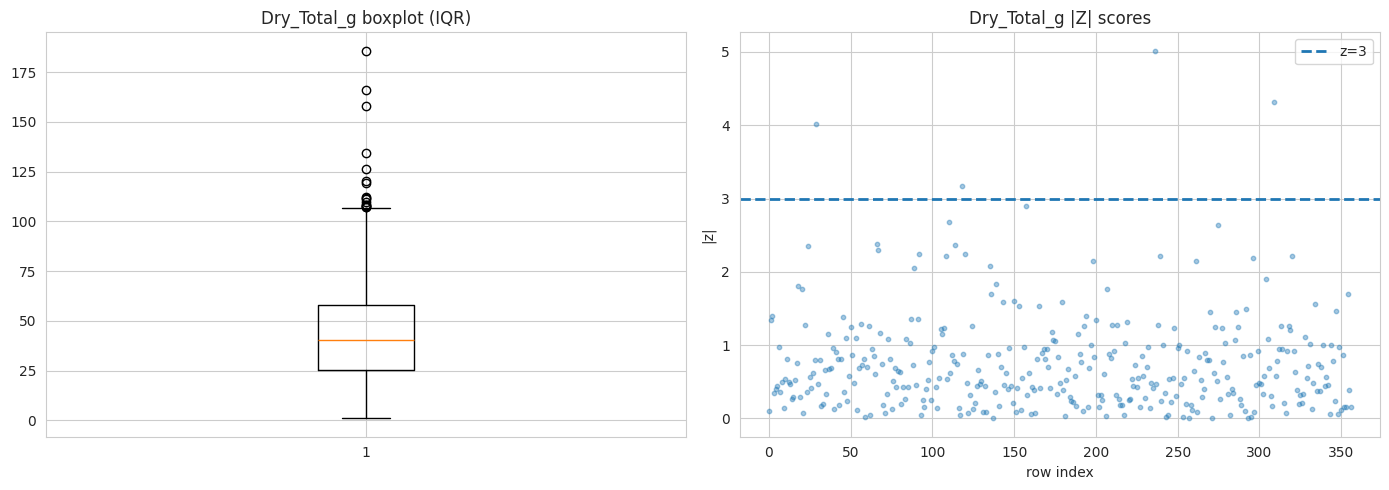

In [10]:
def detect_outliers(df: pd.DataFrame, target: str) -> dict:
    x = df[target].dropna().astype(float)

    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lo = Q1 - 1.5 * IQR
    hi = Q3 + 1.5 * IQR

    iqr_mask = (df[target] < lo) | (df[target] > hi)
    iqr_out = df[iqr_mask]

    mu = x.mean()
    sd = x.std() + 1e-9
    z = np.abs((df[target] - mu) / sd)
    z_out = df[z > 3.0]

    print(f"\nOutliers for {target}")
    print(f"  IQR bounds: [{lo:.2f}, {hi:.2f}] -> {len(iqr_out)} rows ({len(iqr_out)/len(df)*100:.1f}%)")
    print(f"  Z>3.0 -> {len(z_out)} rows ({len(z_out)/len(df)*100:.1f}%)")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].boxplot(x, vert=True)
    axes[0].set_title(f"{target} boxplot (IQR)")

    axes[1].scatter(np.arange(len(df)), z, alpha=0.4, s=10)
    axes[1].axhline(3.0, linestyle="--", linewidth=2, label="z=3")
    axes[1].set_title(f"{target} |Z| scores")
    axes[1].set_xlabel("row index")
    axes[1].set_ylabel("|z|")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return {"iqr_outliers": iqr_out, "z_outliers": z_out}

outliers = {t: detect_outliers(df, t) for t in TARGET_COLS}


**Takeaway:** The boxplots show that each target has a long upper tail, so outliers are mostly very high biomass samples (not random negatives). Because high-end outliers exist, it’s reasonable to use robust training choices (e.g., SmoothL1/Huber, clipping, ensembling) so a small number of extreme samples don’t dominate learning.

In [11]:
def show_images_by_condition(
    df,
    data_root,
    split="train",          # kept only so your old calls still work
    sort_by="Dry_Total_g",
    ascending=False,
    n_images=9,
    filters=None,
    ncols=3,
):
    d = df.copy()

    if filters:
        for k, v in filters.items():
            d = d[d[k] == v]

    d = d.sort_values(sort_by, ascending=ascending).head(n_images)

    nrows = (n_images + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
    axes = np.array(axes).reshape(-1)

    for j, (_, row) in enumerate(d.iterrows()):
        ax = axes[j]
        img_path = Path(data_root) / row["image_path"]   # <- SIMPLE FIX

        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{sort_by}={row[sort_by]:.1f}g", fontsize=10)

    for k in range(j + 1, len(axes)):
        axes[k].axis("off")

    plt.tight_layout()
    plt.show()


High biomass examples:


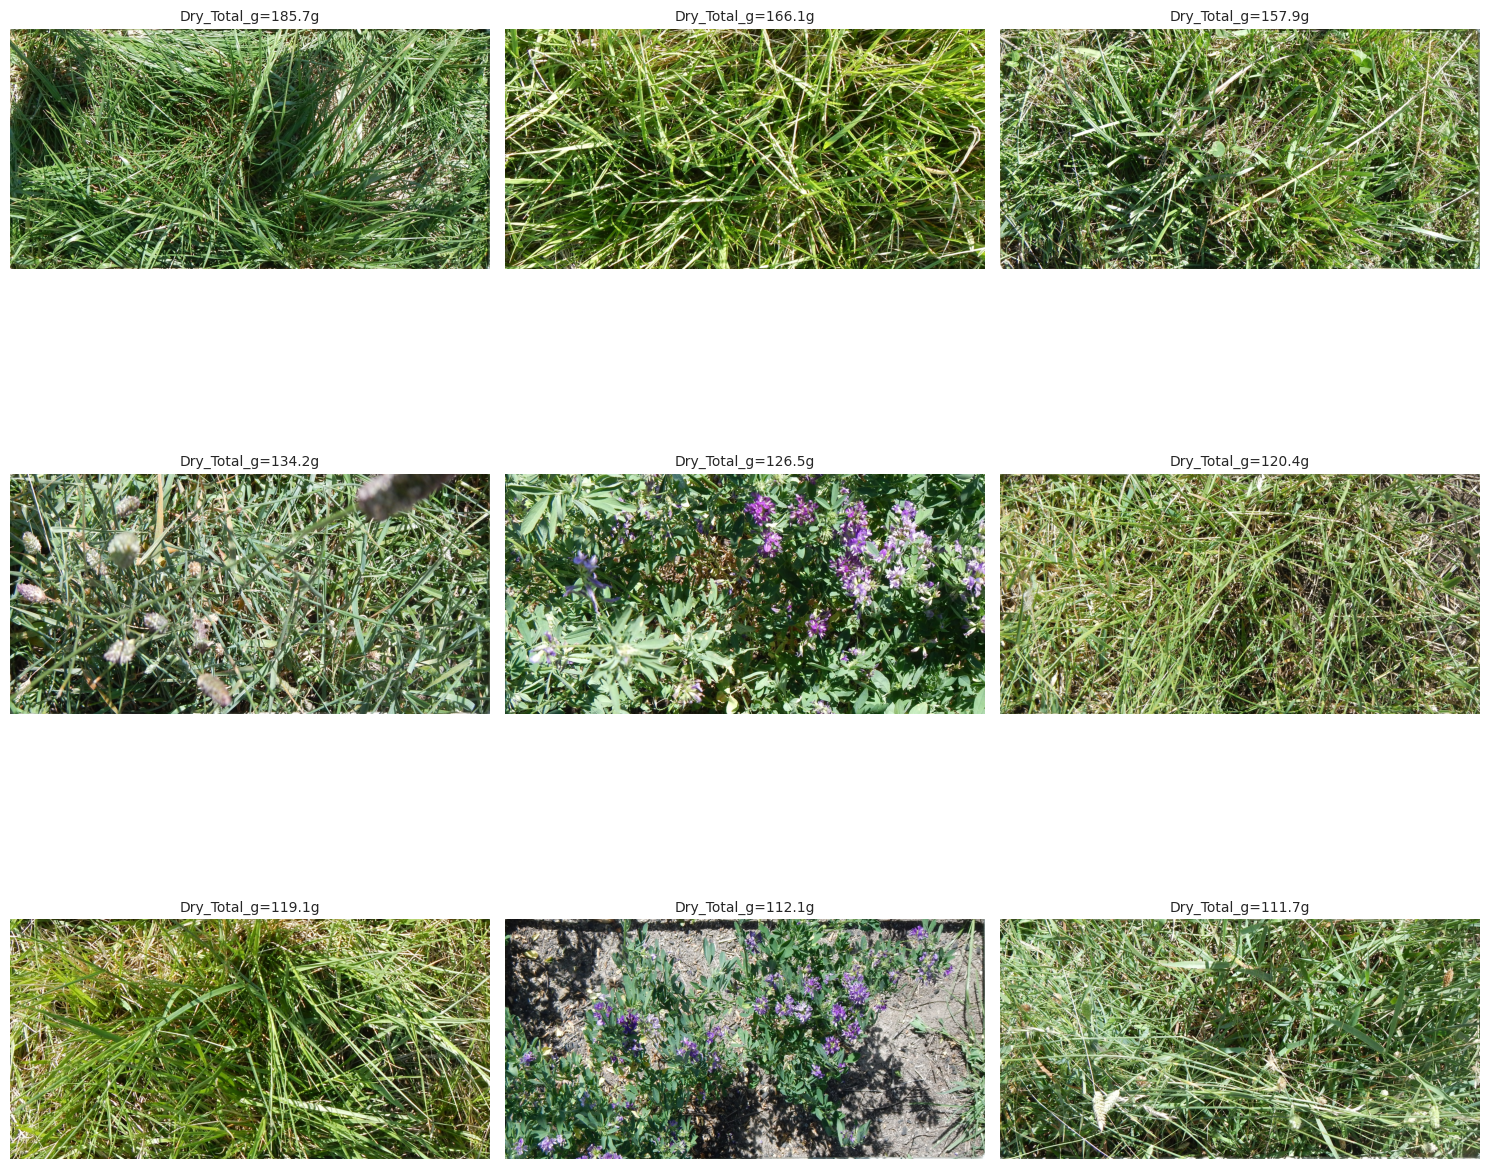

In [12]:
print("\nHigh biomass examples:")
show_images_by_condition(df, DATA_ROOT, split="train", sort_by="Dry_Total_g", ascending=False, n_images=9)


Low biomass examples:


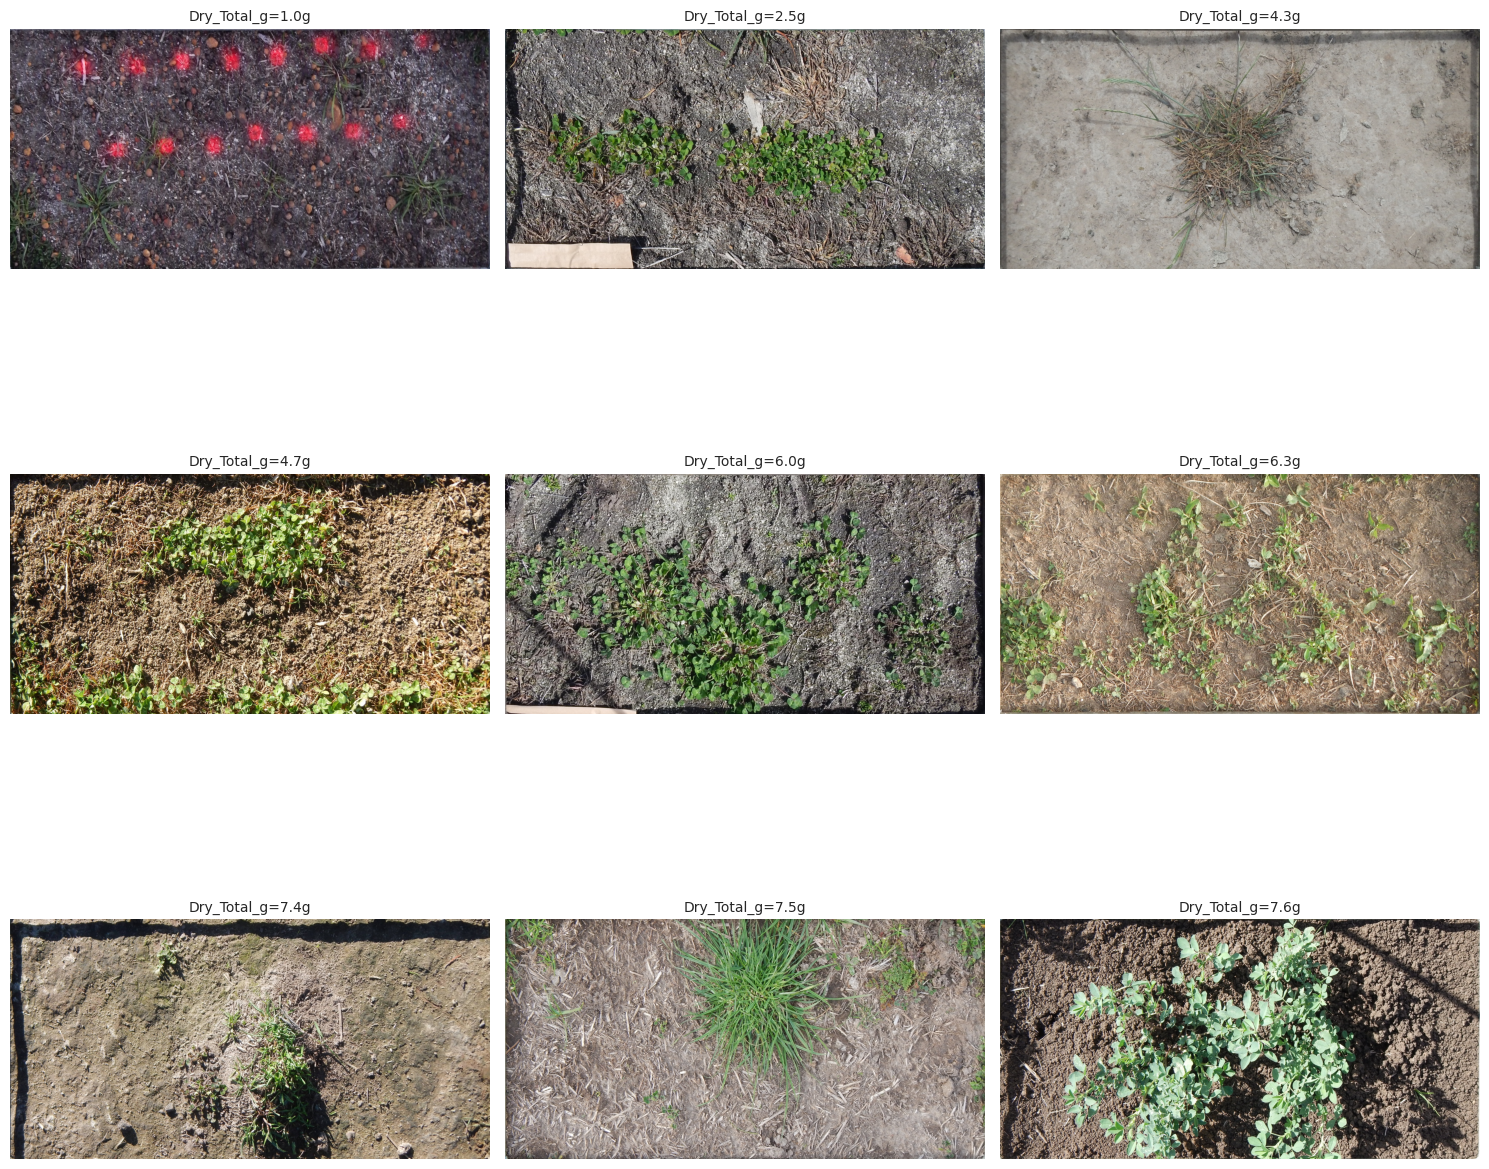

In [13]:

print("\nLow biomass examples:")
show_images_by_condition(df, DATA_ROOT, split="train", sort_by="Dry_Total_g", ascending=True, n_images=9)